# Machine Characteristics and Efficiency Maps

Machine characteristics such as speed, torque, voltage, currents, frequency etc. can be efficiently calculated by equivalent circuit models which are included in the module 'femagtools.machine':

In [1]:
import femagtools.machine
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(message)s')
p = 4
r1 = 0.0806
ls = 0.0
ld = [0.0014522728, 0.0014522728]
lq = [0.0038278836, 0.0032154]
psim = [0.11171972, 0.11171972]
i1 = [80.0]
beta = [-41.1, 0]

pm = femagtools.machine.PmRelMachineLdq(3, p, psim, ld, lq, r1, beta, i1, ls)

2024-01-12 14:23:16,348 loss map missing: i1 1  beta 2 (sizes should be larger than 3)


Note: The warning message can be ignored. It indicates that the loss values are missing.

For example we can calculate the iq and id current for a given torque of 170 Nm:

In [2]:
pm.check_extrapolation = False
pm.iqd_torque(170)

array([ 87.16183677, -71.16227683])

In [3]:
pm.iqdbnds

[(0.0, 113.13708498984761), (-0.0, 0)]

Or reversely: we calculate the torque with given id, iq current:

In [4]:
pm.torque_iqd(87.16183261, -71.16228193)

169.9999999732831

For the transformation of i1-beta and id-iq components there are corresponding functions:

In [5]:
femagtools.machine.betai1(87.16, -71.16)

(-0.6846789860301091, 79.56321763227024)

In [6]:
femagtools.machine.iqd(-0.685, 79.56)

array([ 87.13362822, -71.18509698])

Show the torque vs beta curve:

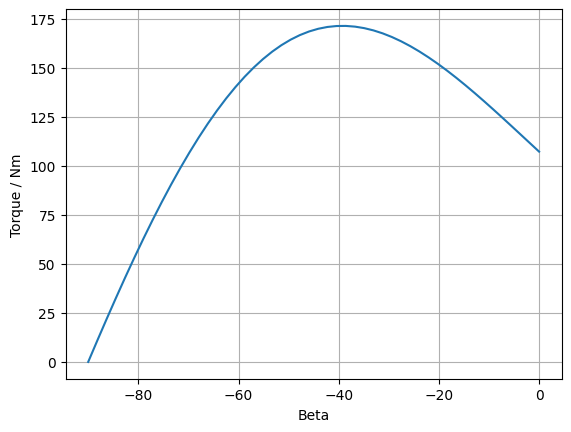

In [7]:
import matplotlib.pyplot as plt
import numpy as np

i1max = 80
beta=np.linspace(-np.pi/2, 0)
plt.plot(180*beta/np.pi, [pm.torque_iqd(*femagtools.machine.iqd(b, i1max)) 
                          for b in beta])
plt.xlabel('Beta')
plt.ylabel('Torque / Nm')
plt.grid()

The maximum torque of i1 max:

In [8]:
pm.torquemax(i1max)

171.40910469993673

Calculate the amplitude of the phase voltage at frequency 75 Hz:

In [9]:
f1 = 75
w1 = 2*np.pi*f1
np.linalg.norm(pm.uqd(w1, 87.16183261, -71.16228193))

165.10379403723468

Find the frequency from maximum torque and voltage:

In [10]:
Tmax = 170
u1 = 230.0

w1 = pm.w1_umax(u1, *pm.iqd_torque(Tmax))
print("Frequency {}".format(w1/np.pi/2))

Frequency 150.96101553644635


Plot the speed torque characteristics:

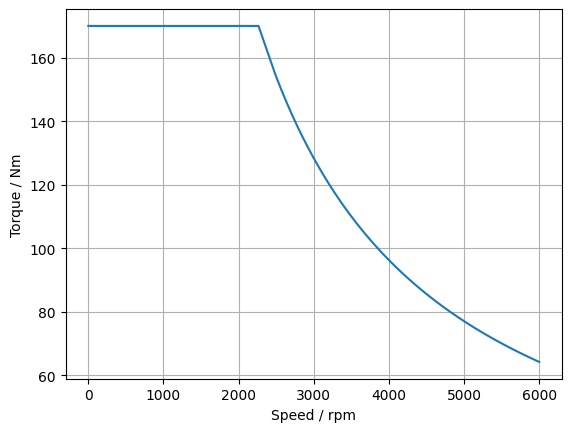

In [11]:
def torque(T, pmax, wm):
    """shaft torque as a function of rotor angular speed"""
    if wm <= pmax / T:
        return T
    return pmax / wm

nmax = 6000/60
pmax = w1/p*Tmax
n = np.append(np.linspace(0, w1/2/np.pi/p),
              np.linspace(1.1*w1/2/np.pi/p, nmax))

plt.plot(60*n, [torque(Tmax, pmax, 2*np.pi*nx) for nx in n])
plt.ylabel('Torque / Nm')
plt.xlabel('Speed / rpm')
plt.grid()

Show the speed characterstics plot with the motor parameters from a Ld-Lq-Identification:

In [12]:
bch = femagtools.read_bchfile('femag/LDQ-0-90.BCH')
pm = femagtools.machine.create(bch, r1 = 0.05, ls = 0)
Tmax = 350
char = pm.characteristics(Tmax, n=6000/60, u1max=230, with_pmconst=True, with_torque_corr=True)

2024-01-12 14:23:16,747 ld-lq 5 x 7
2024-01-12 14:23:16,748 Stator Subregions: ['StYoke', 'StTeeth', 'Rotor', 'mag']
2024-01-12 14:23:16,748 losses for speed 50.000000
2024-01-12 14:23:17,098 loss map missing: 'speed'
2024-01-12 14:23:17,125 Type speed 1903.1672 nmax 6000.0 T 350.0 i1max 168.1
2024-01-12 14:23:17,294 Speedrange T=350 Nm [0, 31.71945395522789, 65.85972697761395, 100.0]
2024-01-12 14:23:17,295 sample intervals [19, 20, 20]
2024-01-12 14:23:17,306 Pmax 69.8 kW
2024-01-12 14:23:17,307 RANGE MTPA 20: 33.426468 -- 65.859727
2024-01-12 14:23:19,276 RANGE MTPV 20: 67.566741 -- 100.000000


Note that the torque value has been corrected as it was too high for the simulated psid/psiq maps.

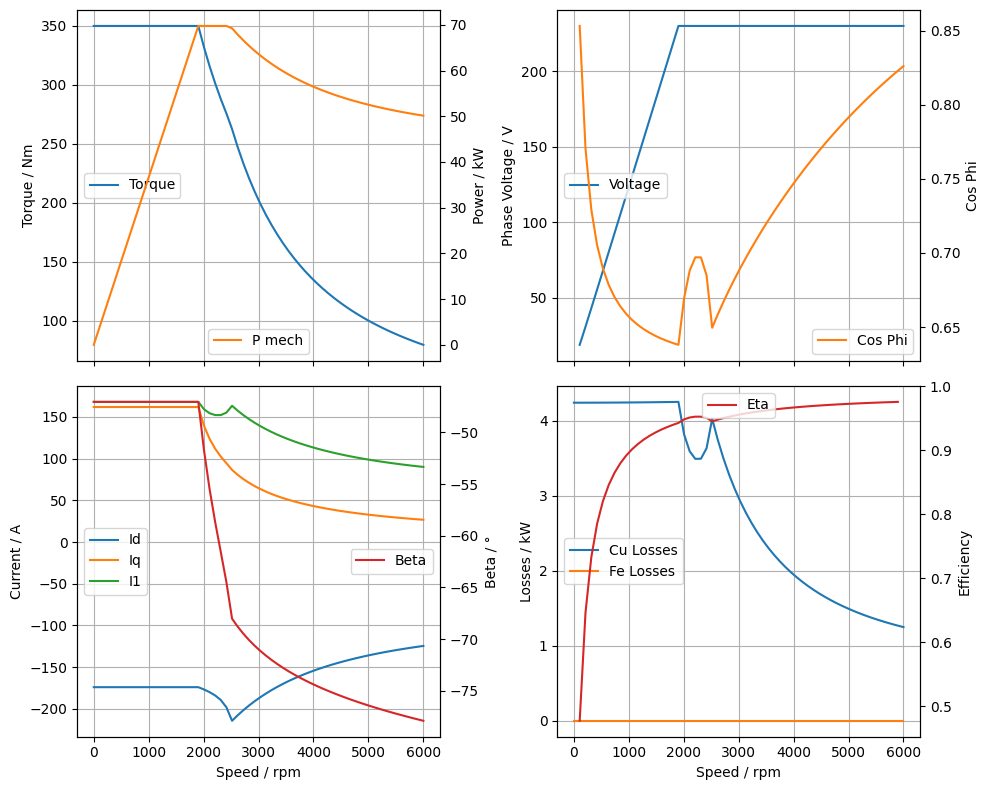

In [13]:
import femagtools.plot
fig = femagtools.plot.characteristics(char)

Note that the loss values are zero due to the missing core loss parameters.

Another option is to create an individual plot:

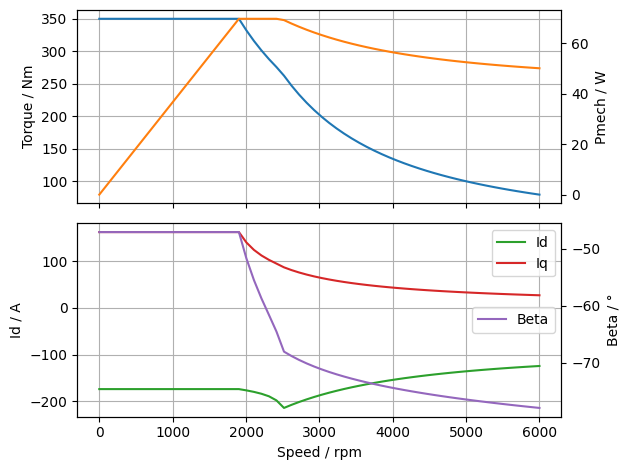

In [14]:
fig, axs = plt.subplots(nrows=2, sharex=True)
speed = 60 * np.array(char['n'])
axs[0].plot(speed, char['T'], color='C0')
ax1 = axs[0].twinx()
ax1.plot(speed, [1e-3*p for p in char['pmech']], color='C1')
axs[0].grid()
axs[0].set_ylabel('Torque / Nm')
ax1.set_ylabel('Pmech / W')
axs[1].plot(speed, char['id'], color='C2', label='Id')
axs[1].plot(speed, char['iq'], color='C3', label='Iq')
axs[1].legend()
ax2 = axs[1].twinx()
ax2.set_ylabel('Beta / °')
ax2.plot(speed, char['beta'], color='C4', label='Beta')
ax2.legend(loc='center right')
axs[1].grid()
axs[1].set_xlabel('Speed / rpm')
axs[1].set_ylabel('Id / A')
fig.tight_layout()

Display the characteristics with a MTPA Plot:

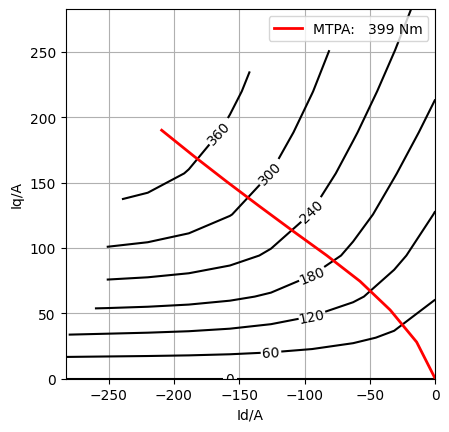

In [15]:
#pm.check_extrapolation = False
femagtools.plot.mtpa(pm, bch.ldq['i1'][-1])

The same current-torque characteristics as a surface plot

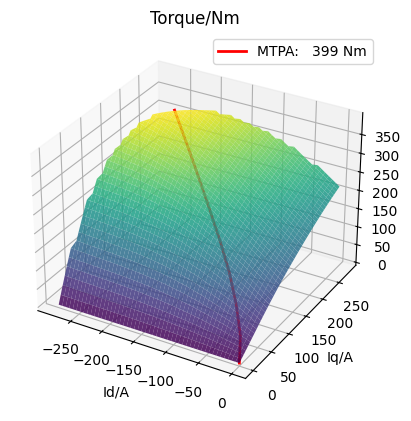

In [16]:
femagtools.plot.mtpa(pm, bch.ldq['i1'][-1], projection='3d')
plt.show()

## Efficiency Map

Let's calculate the efficiency map with reduced torque:

In [17]:
import femagtools.machine.effloss
temp = []
Tmax = 390
u1max = 230
nmax = 6000/60
effmap = femagtools.machine.effloss.efficiency_losses_map(
    pm, u1max, Tmax, temp, nmax)

2024-01-12 14:23:20,802 Type speed 1831.3222 nmax 6000.0 T 390.0 i1max 193.8
2024-01-12 14:23:20,973 Speedrange T=390 Nm [0, 30.5220367638855, 65.26101838194275, 100.0]
2024-01-12 14:23:20,974 sample intervals [18, 20, 20]
2024-01-12 14:23:20,987 Pmax 74.8 kW
2024-01-12 14:23:20,987 RANGE MTPA 20: 32.258986 -- 65.261018
2024-01-12 14:23:22,898 RANGE MTPV 20: 66.997967 -- 100.000000
2024-01-12 14:23:22,999 total speed,torque samples 1439
2024-01-12 14:23:23,420 Losses/Eff Map: 7%
2024-01-12 14:23:23,844 Losses/Eff Map: 13%
2024-01-12 14:23:24,273 Losses/Eff Map: 20%
2024-01-12 14:23:24,687 Losses/Eff Map: 27%
2024-01-12 14:23:25,114 Losses/Eff Map: 33%
2024-01-12 14:23:25,544 Losses/Eff Map: 40%
2024-01-12 14:23:25,966 Losses/Eff Map: 47%
2024-01-12 14:23:26,401 Losses/Eff Map: 53%
2024-01-12 14:23:26,914 Losses/Eff Map: 60%
2024-01-12 14:23:27,683 Losses/Eff Map: 67%
2024-01-12 14:23:28,603 Losses/Eff Map: 73%
2024-01-12 14:23:29,712 Losses/Eff Map: 80%
2024-01-12 14:23:30,863 Losses/E

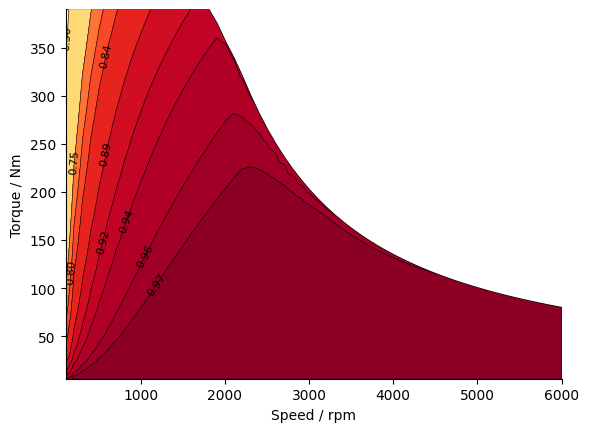

In [18]:
fig, ax = plt.subplots()
cfg = femagtools.plot.efficiency_map(effmap, ax, title='')

## Using an ERG File

The equivalent model can be created with parameters from a ERG file as well:

In [19]:
import femagtools.erg
erg = femagtools.erg.read('femag/ldlq.erg')
pmerg = femagtools.machine.create(erg, r1 = 0, ls = 0, lfe=350)
Tmax = 9500
nmax = 600/60
u1max = 500/np.sqrt(3)
char = pmerg.characteristics(Tmax, n=nmax, u1max=u1max)

2024-01-12 14:23:34,718 loss map missing: 'losses'
2024-01-12 14:23:34,753 Type speed 302.9735 nmax 600.0 T 9500.0 i1max 732.8
2024-01-12 14:23:34,997 Speedrange T=9500 Nm [0, 5.049557523015395, 7.524778761507697, 10.0]
2024-01-12 14:23:34,998 sample intervals [30, 14, 14]
2024-01-12 14:23:35,020 Pmax 301.4 kW
2024-01-12 14:23:35,021 RANGE MTPA 14: 5.226359 -- 7.524779
2024-01-12 14:23:36,752 RANGE MTPV 14: 7.701580 -- 10.000000


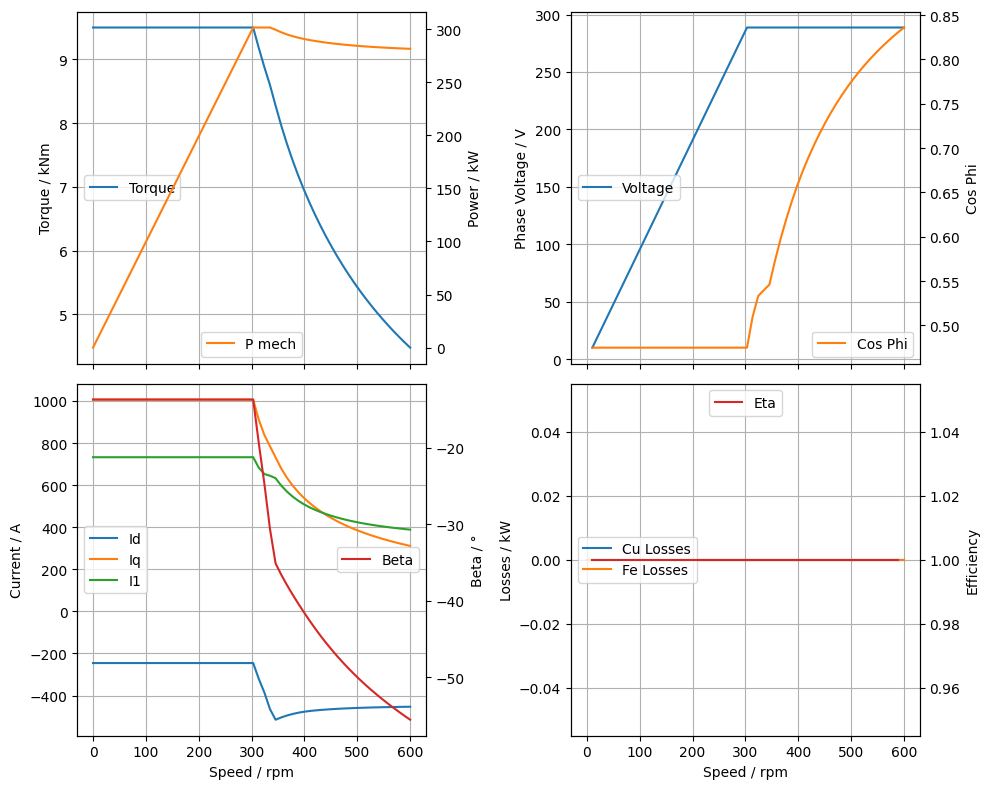

In [20]:
fig = femagtools.plot.characteristics(char)

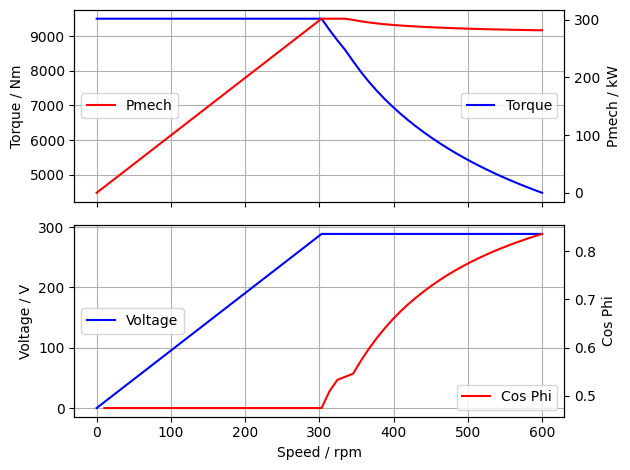

In [21]:
n = 60*np.array(char['n'])
fig, axs = plt.subplots(2, sharex=True)

axs[0].plot(n, char['T'], 'b-', label='Torque')
axs[0].set_ylabel("Torque / Nm")
axs[0].grid()
axs[0].legend(loc='center right')
ax2 = axs[0].twinx()
ax2.plot(n, 1e-3*np.array(char['pmech']), 'r-', label='Pmech')
ax2.set_ylabel("Pmech / kW")
ax2.legend(loc='center left')

axs[1].plot(n, char['u1'], 'b-', label='Voltage')
axs[1].set_ylabel("Voltage / V",)
axs[1].set_xlabel("Speed / rpm")
axs[1].grid()
axs[1].legend(loc='center left')
ax3 = axs[1].twinx()
ax3.plot(n[1:], char['cosphi'][1:], 'r-', label='Cos Phi')
ax3.set_ylabel("Cos Phi")
ax3.legend(loc='lower right')

fig.tight_layout()